In [2]:
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline

import sqlalchemy as sa
from datetime import datetime as dt
from datetime import timedelta
import yfinance as yf
import itertools as it
import pandas as pd

from python.common.common import read_latest_file, read_pickle
from python.config_reader import ConfigReader
from python.common.mysql_connector import MySqlConnector
from schema.data_model import StockPrices, Symbols

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [4]:
# Initialise database connection
engine = MySqlConnector(
    host='localhost',
    user='root',
    password='db_user',
    database='stock_db'
)

con = engine.con

shortlist_stock_stmt = "(SELECT symbol from dim_symbols where country='United States' order by market_cap desc limit 50) UNION ALL (SELECT symbol from dim_symbols where market_type != 'stock')"

shortlist_stock = con.execute(shortlist_stock_stmt).fetchall()

sql_df = pd.read_sql(
    sa.select(
        StockPrices.stock_datetime, StockPrices.symbol, StockPrices.close, StockPrices.volume, Symbols.market_type, Symbols.sector) \
    .join(Symbols) \
    .where(StockPrices.symbol.in_([i[0] for i in shortlist_stock])), con)


In [5]:
sql_df = sql_df.join(pd.get_dummies(sql_df['sector'], prefix='sector_', drop_first=True)).drop('sector', axis=1)
sql_df = sql_df.join(pd.get_dummies(sql_df['market_type'], prefix='market_type_', drop_first=True)).drop('market_type', axis=1)

In [6]:
sql_df.corr()

,close,volume,sector__Consumer Non-Durables,sector__Consumer Services,sector__Energy,sector__Finance,sector__Health Care,sector__Miscellaneous,sector__N/A,sector__Public Utilities,sector__Technology,sector__Transportation,market_type__commodity,market_type__currency,market_type__index,market_type__stock
close,1.000000,0.400111,-0.057898,-0.063709,-0.041147,-0.060050,-0.083047,-0.044801,0.344566,-0.041080,-0.091843,-0.027504,-0.016333,-0.083722,0.544363,-0.344566
volume,0.400111,1.000000,-0.037239,-0.057941,-0.025349,-0.035461,-0.053905,-0.032105,0.251016,-0.026007,-0.073956,-0.018395,-0.027996,-0.051907,0.074782,-0.251016
sector__Consumer Non-Durables,-0.057898,-0.037239,1.000000,-0.099620,-0.044376,-0.063738,-0.093118,-0.054753,-0.146195,-0.044359,-0.130002,-0.031127,-0.047016,-0.087169,-0.055349,0.146195
sector__Consumer Services,-0.063709,-0.057941,-0.099620,1.000000,-0.069386,-0.099660,-0.145599,-0.085611,-0.228589,-0.069360,-0.203269,-0.048670,-0.073513,-0.136297,-0.086542,0.228589
sector__Energy,-0.041147,-0.025349,-0.044376,-0.069386,1.000000,-0.044394,-0.064858,-0.038136,-0.101826,-0.030897,-0.090547,-0.021680,-0.032747,-0.060714,-0.038551,0.101826
sector__Finance,-0.060050,-0.035461,-0.063738,-0.099660,-0.044394,1.000000,-0.093155,-0.054775,-0.146253,-0.044377,-0.130053,-0.031140,-0.047034,-0.087204,-0.055370,0.146253
sector__Health Care,-0.083047,-0.053905,-0.093118,-0.145599,-0.064858,-0.093155,1.000000,-0.080024,-0.213670,-0.064833,-0.190002,-0.045494,-0.068715,-0.127402,-0.080894,0.213670
sector__Miscellaneous,-0.044801,-0.032105,-0.054753,-0.085611,-0.038136,-0.054775,-0.080024,1.000000,-0.125637,-0.038121,-0.111720,-0.026750,-0.040404,-0.074911,-0.047565,0.125637
sector__N/A,0.344566,0.251016,-0.146195,-0.228589,-0.101826,-0.146253,-0.213670,-0.125637,1.000000,-0.101787,-0.298302,-0.071425,0.321596,0.596254,0.378594,-1.000000
sector__Public Utilities,-0.041080,-0.026007,-0.044359,-0.069360,-0.030897,-0.044377,-0.064833,-0.038121,-0.101787,1.000000,-0.090512,-0.021672,-0.032734,-0.060691,-0.038536,0.101787


In [7]:
# Example feature input 
# np.array([
#     [[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1]],
#     [[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1]],
#     [[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1]],
#     [[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1]],
#     [[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1]],
#     [[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1]]
# ]).shape

(6, 5, 3)

In [8]:
# Feature Scaling
sc_close = MinMaxScaler(feature_range = (0, 1))
sc_volume= MinMaxScaler(feature_range = (0, 1))
timesteps = 60 # n of days to train per datapoint
predict_gap = 1 # Predict x days in advanced
symbol_list = sql_df['symbol'].unique()


X_train_list = []
y_train_list = []

# Iterate each stock and create steps individually
for symbol in symbol_list:
    X_train = []
    y_train = []
    
    
    # Creating a data structure with time-steps and 1 output for numeric features
    scaled_close = sc_close.fit_transform(sql_df[sql_df['symbol'] == symbol]['close'].values.reshape(-1,1))
    scaled_volume = sc_volume.fit_transform(sql_df[sql_df['symbol'] == symbol]['volume'].values.reshape(-1,1))
    
    # Creating a data structure with time-steps for non-numerics
    non_numeric_features = []
    for row in sql_df[sql_df['symbol'] == symbol].select_dtypes(include=['uint8']).values:
        row_l = [] 
        for col in row:
            row_l.append([col] * timesteps)
        non_numeric_features.append(row_l)
    
    for i in range(timesteps + predict_gap, scaled_close.shape[0]):
        X_train.append([
            scaled_close[i - timesteps - predict_gap:i - predict_gap, 0],
            scaled_volume[i - timesteps - predict_gap:i - predict_gap, 0],
        ] + non_numeric_features[i])
        y_train.append(scaled_close[i, 0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.array(X_train).transpose((0,2,1))
    X_train_list.append(X_train)
    y_train_list.append(y_train)

combined_X_train = np.concatenate(X_train_list)
combined_y_train = np.concatenate(y_train_list)

In [10]:
X_train.shape

(611, 60, 16)

In [439]:
combined_X_train

array([[[0.03381849, 0.00998729, 0.        , 1.        ],
        [0.        , 0.03109647, 0.        , 1.        ],
        [0.0130501 , 0.01837589, 0.        , 1.        ],
        ...,
        [0.09588715, 0.01495058, 0.        , 1.        ],
        [0.09949906, 0.00719025, 0.        , 1.        ],
        [0.10003655, 0.00366327, 0.        , 1.        ]],

       [[0.        , 0.03109647, 0.        , 1.        ],
        [0.0130501 , 0.01837589, 0.        , 1.        ],
        [0.01234061, 0.01688649, 0.        , 1.        ],
        ...,
        [0.09949906, 0.00719025, 0.        , 1.        ],
        [0.10003655, 0.00366327, 0.        , 1.        ],
        [0.10268096, 0.00474594, 0.        , 1.        ]],

       [[0.0130501 , 0.01837589, 0.        , 1.        ],
        [0.01234061, 0.01688649, 0.        , 1.        ],
        [0.01840345, 0.01153748, 0.        , 1.        ],
        ...,
        [0.10003655, 0.00366327, 0.        , 1.        ],
        [0.10268096, 0.004745

In [408]:
combined_y_train

array([0.10545439, 0.11143122, 0.11429064, ..., 0.78528159, 0.79798083,
       0.82607017])

In [383]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (combined_X_train.shape[1], combined_X_train.shape[2])))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(combined_X_train, combined_y_train, epochs = 20, batch_size = 32)

Epoch 1/20
58/58 [==============================] - 9s 72ms/step - loss: 0.0339
Epoch 2/20
58/58 [==============================] - 4s 63ms/step - loss: 0.0076
Epoch 3/20
58/58 [==============================] - 4s 61ms/step - loss: 0.0069
Epoch 4/20
58/58 [==============================] - 4s 61ms/step - loss: 0.0066
Epoch 5/20
58/58 [==============================] - 3s 60ms/step - loss: 0.0059
Epoch 6/20
58/58 [==============================] - 4s 70ms/step - loss: 0.0056
Epoch 7/20
58/58 [==============================] - 4s 62ms/step - loss: 0.0057
Epoch 8/20
58/58 [==============================] - 4s 70ms/step - loss: 0.0058
Epoch 9/20
58/58 [==============================] - 4s 70ms/step - loss: 0.0056
Epoch 10/20
58/58 [==============================] - 4s 68ms/step - loss: 0.0052
Epoch 11/20
58/58 [==============================] - 3s 60ms/step - loss: 0.0046
Epoch 12/20
58/58 [==============================] - 4s 61ms/step - loss: 0.0047
Epoch 13/20
58/58 [==================

In [274]:
# Saving model
# model.save('./lstm_models/model_2')

INFO:tensorflow:Assets written to: ./lstm_model/model_2\assets


INFO:tensorflow:Assets written to: ./lstm_model/model_2\assets


In [191]:
# Saving model
#model.save('./lstm_model')

INFO:tensorflow:Assets written to: ./lstm_model\assets


INFO:tensorflow:Assets written to: ./lstm_model\assets


In [104]:
# model = Sequential()

# #Adding the first LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# # Adding a second LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 100))
# model.add(Dropout(0.4))

# # Adding the output layer
# model.add(Dense(units = 1))

# # Compiling the RNN
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# # Fitting the RNN to the Training set
# model.fit(X_train, y_train, epochs = 100, batch_size = 32)

# Validation

In [85]:
model = load_model('lstm_models/model_20')

In [86]:
sql_df = pd.read_sql(
    sa.select(
        StockPrices.stock_datetime, StockPrices.symbol, StockPrices.close, StockPrices.volume, Symbols.market_type, Symbols.sector) \
    .join(Symbols) \
    .where(StockPrices.symbol.in_([i[0] for i in shortlist_stock])) \
    .where(StockPrices.stock_datetime >= '2021-02-17 00:00:00') , con)

sql_df = sql_df.join(pd.get_dummies(sql_df['sector'], prefix='sector_', drop_first=True)).drop('sector', axis=1)
sql_df = sql_df.join(pd.get_dummies(sql_df['market_type'], prefix='market_type_', drop_first=True)).drop('market_type', axis=1)

In [87]:
symbol = 'AAPL'
# Test Validation
X_test = []


# Creating a data structure with time-steps and 1 output for numeric features
scaled_close = sc_close.fit_transform(sql_df[sql_df['symbol'] == symbol]['close'].values.reshape(-1,1))
scaled_volume = sc_volume.fit_transform(sql_df[sql_df['symbol'] == symbol]['volume'].values.reshape(-1,1))

# Creating a data structure with time-steps for non-numerics
non_numeric_features = []
for row in sql_df[sql_df['symbol'] == symbol].select_dtypes(include=['uint8']).values:
    row_l = [] 
    for col in row:
        row_l.append([col] * timesteps)
    non_numeric_features.append(row_l)

for i in range(timesteps + predict_gap, scaled_close.shape[0]):
    X_test.append([
        scaled_close[i - timesteps - predict_gap:i - predict_gap, 0],
        scaled_volume[i - timesteps - predict_gap:i - predict_gap, 0],
    ] + non_numeric_features[i])
X_test = np.array(X_test)
X_test = np.array(X_test).transpose(0,2,1)

In [88]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc_close.inverse_transform(predicted_stock_price)

# Visualising the results

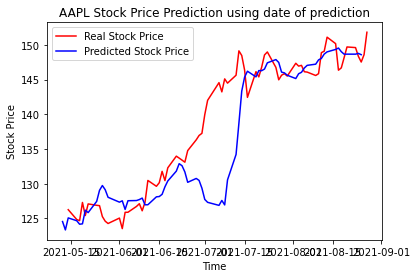

In [89]:
# Using date prediction was made, to visualise prediction
stock_datetime = sql_df[sql_df['symbol'] == symbol][timesteps + predict_gap -1: -1]['stock_datetime']
pred_datetime = sql_df[sql_df['symbol'] == symbol][timesteps - 1: - predict_gap - 1]['stock_datetime']
plt.plot(stock_datetime, sql_df[sql_df['symbol'] == symbol]['close'][predict_gap + timesteps:], color = 'red', label = 'Real Stock Price')
plt.plot(pred_datetime, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('{} Stock Price Prediction using date of prediction'.format(symbol))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

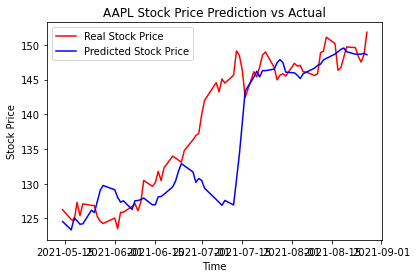

In [90]:
# Using actual stock date to compare accuracy
stock_datetime = sql_df[sql_df['symbol'] == symbol][timesteps + predict_gap -1: -1]['stock_datetime']
plt.plot(stock_datetime, sql_df[sql_df['symbol'] == symbol]['close'][predict_gap + timesteps:], color = 'red', label = 'Real Stock Price')
plt.plot(stock_datetime, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('{} Stock Price Prediction vs Actual'.format(symbol))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

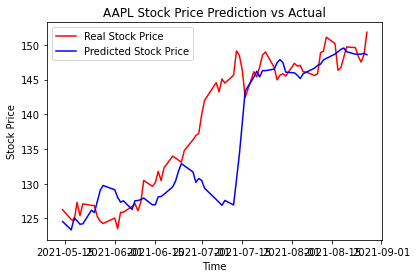

In [91]:
# Using actual stock date to compare accuracy
stock_datetime = sql_df[sql_df['symbol'] == symbol][timesteps + predict_gap -1: -1]['stock_datetime']
plt.plot(stock_datetime, sql_df[sql_df['symbol'] == symbol]['close'][predict_gap + timesteps:], color = 'red', label = 'Real Stock Price')
plt.plot(stock_datetime, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('{} Stock Price Prediction vs Actual'.format(symbol))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [92]:
from sklearn.metrics import mean_squared_error

In [93]:
actual = sql_df[sql_df['symbol'] == symbol]['close'][predict_gap + timesteps:]
pred = predicted_stock_price

In [94]:
mean_squared_error(actual, pred)

37.460056327693984

In [95]:
math.sqrt(mean_squared_error(actual, pred))

6.120462100829805